---


1. For the start we'll download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>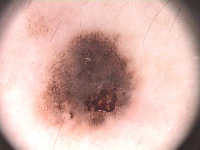</td><td>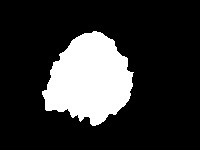</td></tr></table>

2. Unzip .rar файл.
3. Please note that the `PH2 Dataset images` folder must be located in the same place as the ipynb notebook.

These are photographs of two types of **skin lesions:** melanoma and moles.
In this task, we will not be concerned with classifying them, but will **segment** them.

In [1]:
! wget https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-12-25 07:56:57--  https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t0ichx42vg218hc/PH2Dataset.rar [following]
--2021-12-25 07:56:57--  https://www.dropbox.com/s/raw/t0ichx42vg218hc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc108d6fdc7d39887038b9db5e37.dl.dropboxusercontent.com/cd/0/inline/BcjeHmWPAHxghqmRA43tdzjhoaccA6vOL3Jg9DnGifsEE0MGhghD83WeQPteTvRDvRWuz-L0oQND2frH4KMDoKUhAQo0Jvs7ewJcb-TEDghfIXhsqkw2ReGXQZVUB-5UqZ5q3NUKYItwVFLl1JvlL0Gv/file# [following]
--2021-12-25 07:56:58--  https://uc108d6fdc7d39887038b9db5e37.dl.dropboxusercontent.com/cd/0/inline/BcjeHmWPAHxghqmRA43tdzjhoaccA6vOL3Jg9DnGifsEE0MGhghD83WeQPteTvRDvRWuz-L0oQND2frH4KM

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

The structure of the dataset is as follows:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Here `X.bmp` is the image to be segmented,` X_lesion.bmp` is the result of the segmentation.

You can use **skimage** to load the dataset: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):

    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images are in different sizes. Let's resize them to $256\times256 $ pixels. To resize images, you can use
 [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
This function will also automatically normalize images in the range $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)

X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions] 

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')


Loaded 200 images


To make sure everything is correct, we will draw some images.

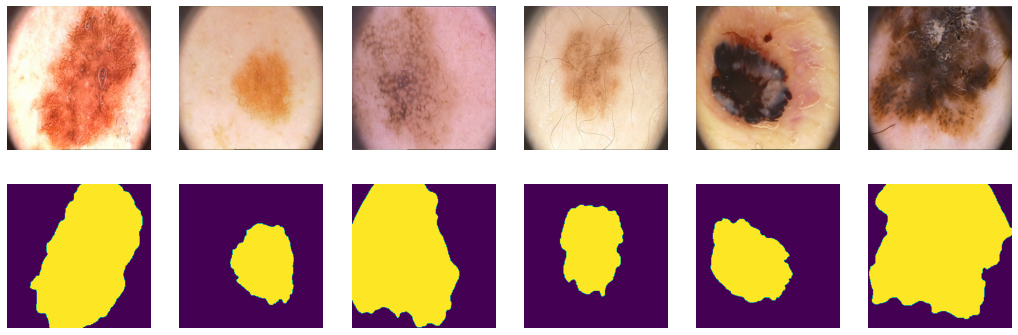

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Divide our 200 images by 100/50/50
 for training, validation and test respectively

In [7]:
ix = np.random.choice(len(X), len(X), False) 
tr, val, ts = np.split(ix, [100, 150]) 

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch dataloader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Implementation of various architectures:
Your assignment will be to write several neural network architectures to solve the semantic segmentation problem. Compare their quality on the test and try different loss functions for them.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

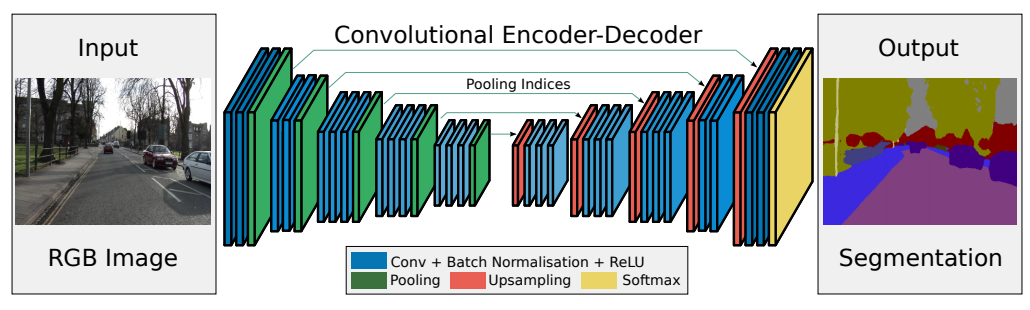

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Take a close look at what the model consists of and why certain blocks are selected.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
from torchvision import models, datasets, transforms

# Look at VGG16 with BatchNorm
models.vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
class convBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(convBatchNormRelu, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            convBatchNormRelu(3, 64, 3, 1, 1),
            convBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            convBatchNormRelu(64, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            convBatchNormRelu(128, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            convBatchNormRelu(256, 512, 3, 1, 1),
            convBatchNormRelu(512, 512, 3, 1, 1),
            convBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16


        # bottleneck
        self.bottle_neck = nn.Sequential(
            convBatchNormRelu(512, 1024, 1, 1, 0),
            convBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            convBatchNormRelu(512, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            convBatchNormRelu(256, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            convBatchNormRelu(128, 64, 3, 1, 1),
            convBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            convBatchNormRelu(64, 1, 3, 1, 1),
            convBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # no activation required in the last layer
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(bottle_neck, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))

        # no activation
        return d0

## Метрика

This section suggests using the following metric to assess quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of the pixels found in both the prediction mask and the main truth mask, while the union (A ∪ B) simply consists of all the pixels found in either the prediction mask or the target mask.


Let's take a look at truth (left) and prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) # Will be zero if both are 0 
    union = (outputs | labels).float().sum((1, 2))        # Will be zero if Truth=0 or Prediction=0 
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # torch.clamp(20 * (iou - 0.5), 0, 10) - обрезать значения 20 * (iou - 0.5) по отрезку [0, 10], .ceil() - округление в большую сторону
    # An Intersection over Union score > 0.5 is normally considered a “good” prediction - https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

    return thresholded  # 

## Loss function [1 point]

As important as the architecture is to define a **optimizer** and **loss function.**

The loss function is what we are trying to minimize. Many of them can be used for the problem of binary semantic segmentation.

A popular method for binary segmentation is *binary cross-entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ this is target of the desired result and $\hat y$ if output of model. $\sigma$ - this is [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function), which convert real number $\mathbb R$ in probability $[0,1]$.

However, this loss suffers from problems of numerical instability. The most important thing is $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first and is less prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_pred, y_real, eps=1e-3):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

    return torch.mean(torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred))))

In [116]:
# bce_loss test
bce_loss(torch.rand(10, 1, 100, 100), torch.rand(10, 1, 100, 100)).shape

torch.Size([])

## Training [1 point]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, scheduler, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        avg_loss_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss_tr += loss / len(data_tr)
        toc = time()
        print('loss_tr: %f' % avg_loss_tr)
        scheduler.step()

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad(): # detach 
            for X_batch, Y_batch in data_val:
                Y_hat = model(X_batch.to(device))
                loss =  loss_fn(Y_hat, Y_batch.to(device))
                avg_loss_val += loss / len(data_val)

        print('loss_val: %f' % avg_loss_val)

        # Visualize tools
        clear_output(wait=True)

        Y_hat = predict(model, X_val).cpu()

        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            # plt.imshow(np.rollaxis(X_batch[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss_tr: %f, loss_val: %f' % (epoch+1, epochs, avg_loss_tr, avg_loss_val))
        plt.show()

## Inference [1 point]

After training the model, this function can be used to predict segmentation on new data:

In [17]:
def predict(model, data):
    model.eval()  # testing mode
    # X_pred = [X_batch for X_batch, _ in data]

    with torch.no_grad(): # detach 
          Y_pred = model(data.to(device))
          Y_pred = torch.sigmoid(Y_pred) 
          Y_pred = Y_pred > 0.5

    return Y_pred
    # return np.array(Y_pred)

In [18]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)


## Highlight: training

Train your model. Note that you need to train before convergence. If the specified number of epochs (20) is not enough, try changing the number of epochs until the algorithm converges. The convergence is determined by the change in the loss function on the validation set.
You can play around with the optimizer options until you find the best one for you.

In [19]:
model_1 = SegNet().to(device)

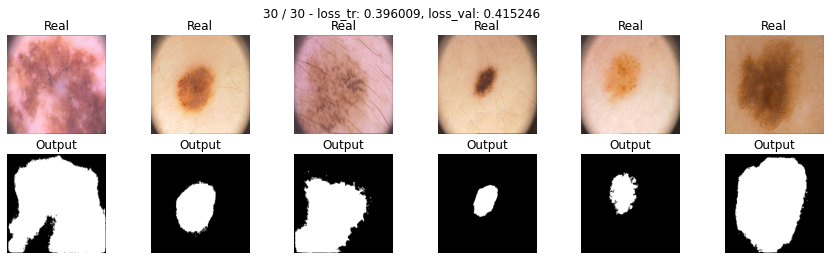

In [20]:
max_epochs = 30
opt = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_1, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [21]:
model_2 = SegNet().to(device)

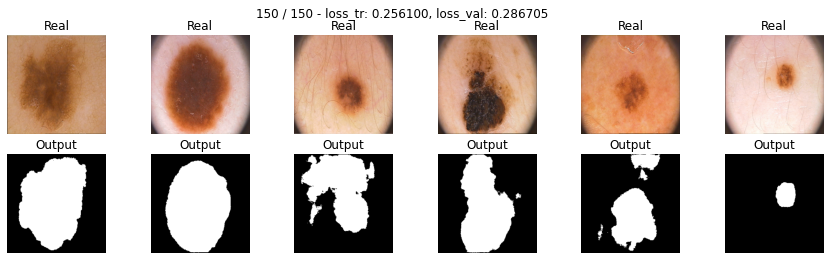

In [22]:
max_epochs = 150
opt = torch.optim.AdamW(model_2.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(model_2, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [23]:
model_3 = SegNet().to(device)

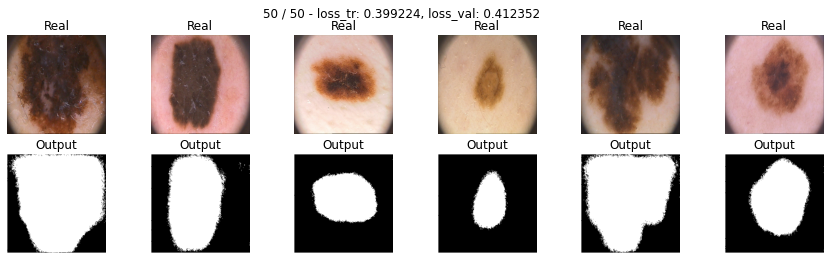

In [24]:
max_epochs = 50
opt = torch.optim.Adam(model_3.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
train(model_3, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [25]:
model_4 = SegNet().to(device)

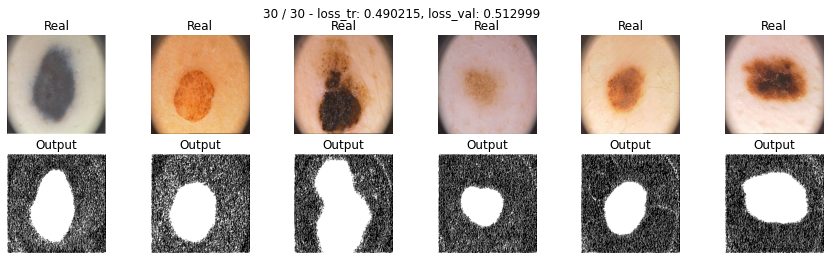

In [26]:
max_epochs = 30
opt = optim.Adam(model_4.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_4, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [27]:
model_5 = SegNet().to(device)

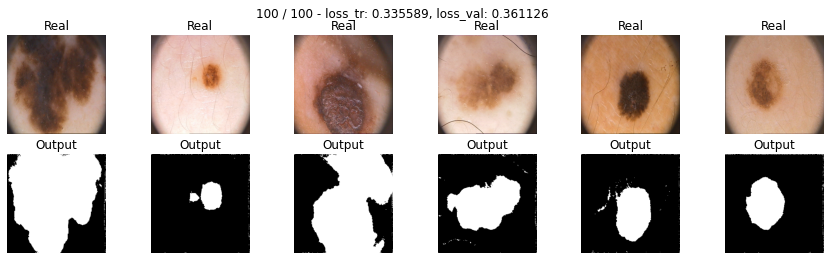

In [28]:
max_epochs = 100
opt = torch.optim.AdamW(model_5.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(model_5, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

Look at results with different parameters:

In [29]:
model_score_1 = score_model(model_1, iou_pytorch, data_val)
model_score_2 = score_model(model_2, iou_pytorch, data_val)
model_score_3 = score_model(model_3, iou_pytorch, data_val)
model_score_4 = score_model(model_4, iou_pytorch, data_val)
model_score_5 = score_model(model_5, iou_pytorch, data_val)

In [30]:
print(f'Score of model_1 is {model_score_1}')
print(f'Score of model_2 is {model_score_2}')
print(f'Score of model_3 is {model_score_3}')
print(f'Score of model_4 is {model_score_4}')
print(f'Score of model_5 is {model_score_5}')

Score of model_1 is 0.6140000522136688
Score of model_2 is 0.7199999988079071
Score of model_3 is 0.535999983549118
Score of model_4 is 0.2019999921321869
Score of model_5 is 0.7500000298023224


**Conclusion:** As we could see model_5 has better score. Probably there is a light overfitting because of scale of little sample size.

**Score: 0.7500000298023224**

-----------------------------------------------------------------------------------------

## Additional loss functions [2 points] 

In this section, you will need to implement two loss functions:
 DICE and Focal loss.
 If you are not learning something, the chances are high that you are mistaken or learn too few eras, before sounding the alarm, try to sort out the various options and make sure that in all other setups the network achieves the desired result. SPOILER: She will learn with all the losses suggested in this task.

**1. Dice coefficient:** Given the two masks $ X $ and $ Y $, the general metric for measuring the distance between the two masks is given as follows:
$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Remember to think about the numerical instability that occurs in the mathematical formula.


## SegNet + Dice Coefficient

In [31]:
def dice_loss(y_pred, y_real, smooth=1e-8):
    y_pred = torch.sigmoid(y_pred)
    num = 2 * (y_pred * y_real).sum()
    den = (y_pred + y_real).sum()
    res = 1 - ((num + smooth) / (den + smooth)) / 65536
    return res 

In [32]:
model_1_dice = SegNet().to(device)  

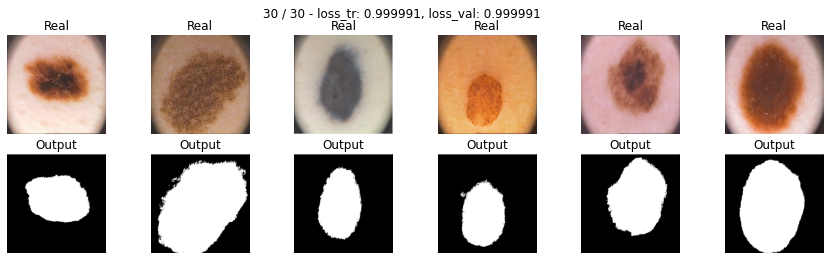

In [33]:
max_epochs = 30
opt = optim.Adam(model_1_dice.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_1_dice, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [34]:
model_2_dice = SegNet().to(device)

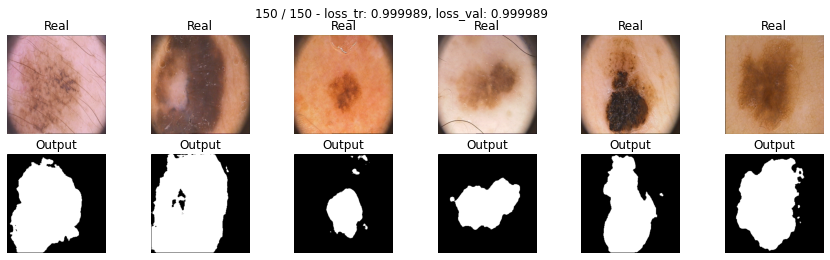

In [35]:
max_epochs = 150
opt = torch.optim.AdamW(model_2_dice.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(model_2_dice, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [36]:
model_3_dice = SegNet().to(device)

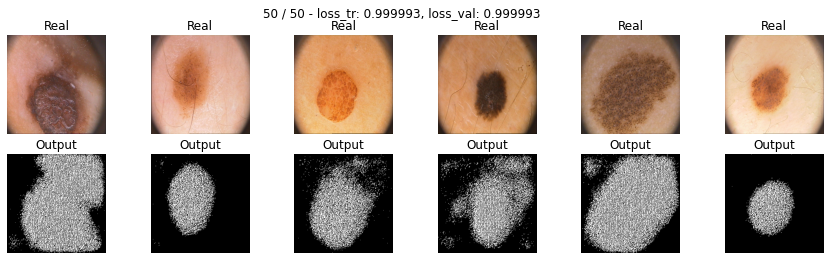

In [37]:
max_epochs = 50
opt = torch.optim.Adam(model_3_dice.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
train(model_3_dice, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [38]:
model_4_dice = SegNet().to(device)

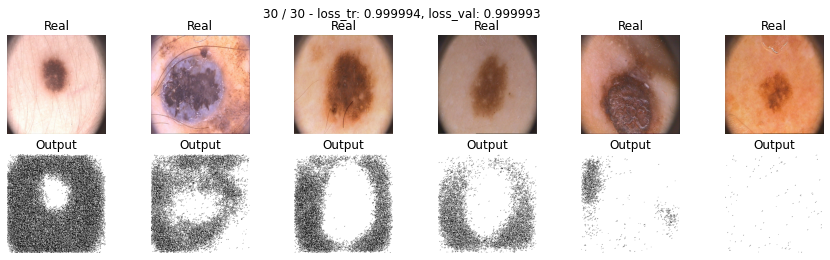

In [39]:
max_epochs = 30
opt = optim.Adam(model_4_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_4_dice , opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [40]:
model_5_dice = SegNet().to(device)

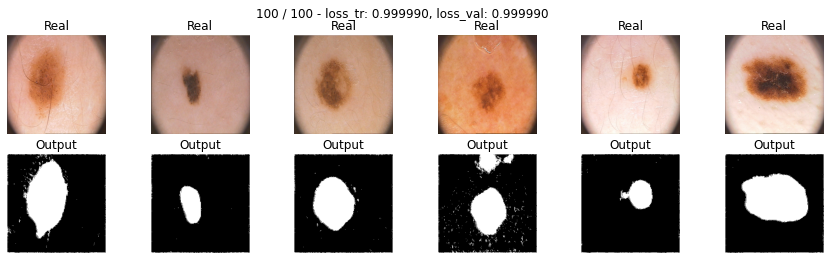

In [41]:
max_epochs = 100
opt = torch.optim.AdamW(model_5_dice.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(model_5_dice, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [42]:
model_score_1_dice = score_model(model_1_dice, iou_pytorch, data_val)
model_score_2_dice = score_model(model_2_dice, iou_pytorch, data_val)
model_score_3_dice = score_model(model_3_dice, iou_pytorch, data_val)
model_score_4_dice = score_model(model_4_dice, iou_pytorch, data_val)
model_score_5_dice = score_model(model_5_dice, iou_pytorch, data_val)

Look at results with different parameters using Dice coef:

In [43]:
print(f'Score of model_1_dice is {model_score_1_dice}')
print(f'Score of model_2_dice is {model_score_2_dice}')
print(f'Score of model_3_dice is {model_score_3_dice}')
print(f'Score of model_4_dice is {model_score_4_dice}')
print(f'Score of model_5_dice is {model_score_5_dice}')

Score of model_1_dice is 0.6500000059604645
Score of model_2_dice is 0.785999983549118
Score of model_3_dice is 0.07600000500679016
Score of model_4_dice is 0.11600000411272049
Score of model_5_dice is 0.6139999628067017


**Conclusion:** Now we could notice that model_2 has better results than other models and model_5 shows worse results than it was showed in previous experiment. Furthermore model_4 and model_3 shows the worst results i've ever seen.

**Score: 0.785999983549118**

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Okay, we already know how to do BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to benefit the **majority** class (background) versus the **minorit** class (foreground). Therefore, weights are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $ \ alpha_i $ is defined as the inverse frequency of the class of that pixel $ i $, so that minority class observations weigh more in relation to the majority class.

Another recent addition is a weighted pixel variant, which weights each pixel according to the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix the value $\gamma=2$.

--------------------------------------------------------------------------------


In [44]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    pt = torch.exp(-bce_loss(y_real, y_pred))
    focal_loss = (1-pt)**gamma * bce_loss(y_real, y_pred)

    return focal_loss.mean()

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         bce_loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
#         loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
#         return loss


In [45]:
model_1_focal = SegNet().to(device)

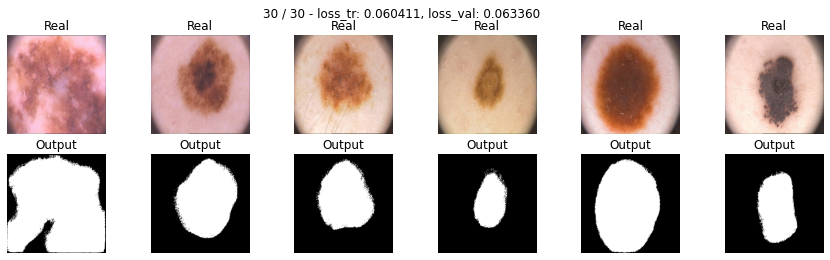

In [46]:
max_epochs = 30
opt = optim.Adam(model_1_focal.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_1_focal, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [47]:
model_2_focal = SegNet().to(device)

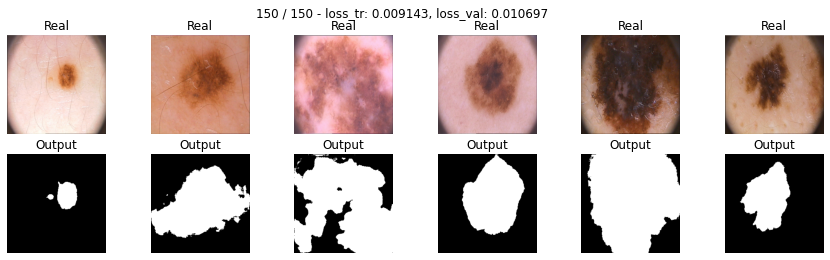

In [48]:
max_epochs = 150
opt = torch.optim.AdamW(model_2_focal.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(model_2_focal, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [49]:
model_3_focal = SegNet().to(device)

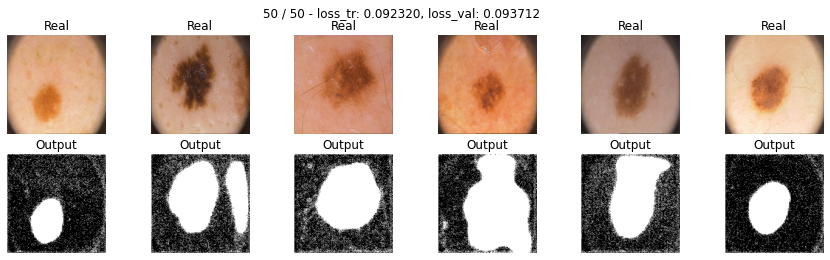

In [50]:
max_epochs = 50
opt = torch.optim.Adam(model_3_focal.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
train(model_3_focal, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [51]:
model_4_focal = SegNet().to(device)

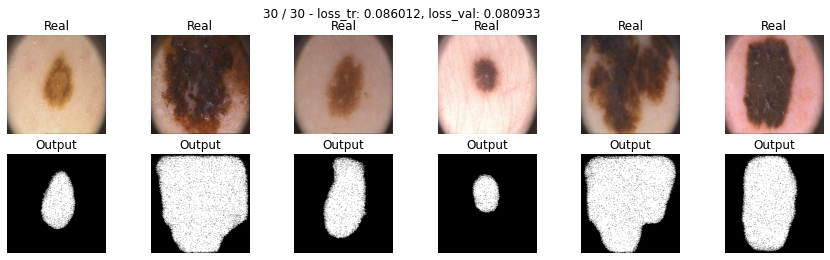

In [52]:
max_epochs = 30
opt = optim.Adam(model_4_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(model_4_focal, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [53]:
model_5_focal = SegNet().to(device)

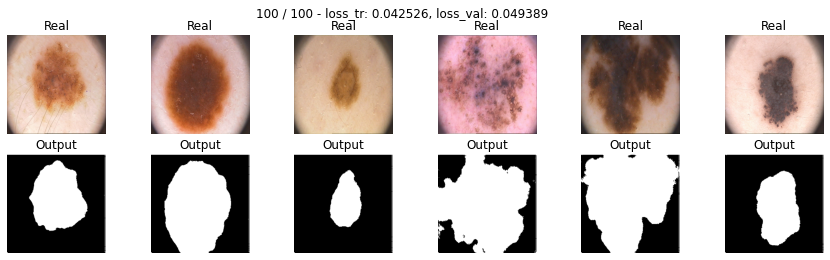

In [54]:
max_epochs = 100
opt = torch.optim.AdamW(model_5_focal.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(model_5_focal, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [55]:
model_score_1_focal = score_model(model_1_focal, iou_pytorch, data_val)
model_score_2_focal = score_model(model_2_focal, iou_pytorch, data_val)
model_score_3_focal = score_model(model_3_focal, iou_pytorch, data_val)
model_score_4_focal = score_model(model_4_focal, iou_pytorch, data_val)
model_score_5_focal = score_model(model_5_focal, iou_pytorch, data_val)

Look at results with different parameters with Focal Loss:

In [56]:
print(f'Score of model_1_focal is {model_score_1_focal}')
print(f'Score of model_2_focal is {model_score_2_focal}')
print(f'Score of model_3_focal is {model_score_3_focal}')
print(f'Score of model_4_focal is {model_score_4_focal}')
print(f'Score of model_5_focal is {model_score_5_focal}')

Score of model_1_focal is 0.6159999966621399
Score of model_2_focal is 0.7020000219345093
Score of model_3_focal is 0.27399998903274536
Score of model_4_focal is 0.5719999670982361
Score of model_5_focal is 0.6540000140666962


**Conclusion:** In this training we could see that model_2 shows better results than others. The same was in second experiment.

**Score: 0.7020000219345093**

#Table for SegNet models

In [57]:
import pandas as pd

In [58]:
segnet_table = pd.DataFrame.from_dict(data={'SegNet with bce loss':[model_score_1, model_score_2, model_score_3, model_score_4, model_score_5],
                                            'SegNet with dice coef':[model_score_1_dice, model_score_2_dice, model_score_3_dice, model_score_4_dice, model_score_5_dice],
                                            'SegNet with focal loss':[model_score_1_focal, model_score_2_focal, model_score_3_focal, model_score_4_focal, model_score_5_focal]},
                                      orient='index', columns=['Model №1', 'Model №2', 'Model №3', 'Model №4', 'Model №5'])
segnet_table

Model №1  Model №2  Model №3  Model №4  Model №5
SegNet with bce loss       0.614     0.720     0.536     0.202     0.750
SegNet with dice coef      0.650     0.786     0.076     0.116     0.614
SegNet with focal loss     0.616     0.702     0.274     0.572     0.654

##Final conclusions:
1. As we could see second model shows the best results in 2 of 3 experiments(bce_loss, focal_loss).
2. As i see that score of model№2 and model №5 are mirrored and depend on losses.
2. The worst score was demonstrated by third model(Adam optimizer + lr = 3e-4) and forth model with Adam optimizer with lr = 1e-4.
3. Model with dice coef was worked better only with second model.
4. The best results overall was reached by **SegNet+bce** and **SegNet+focal**.
5. The worst results overall was reached by **SegNet+dice**.

-----------------------------------------------------------------------------------------

# U-Net [2 points]

[**U-Net**](https://arxiv.org/abs/1505.04597) — it is a neural network architecture that takes an image and outputs it. It was originally conceived for semantic segmentation (as we will use it), but it is so successful that it has since been used in other contexts. Taking a medical image as input, it will output a grayscale image, where the intensity of each pixel depends on the likelihood that this pixel belongs to the area of ​​interest.

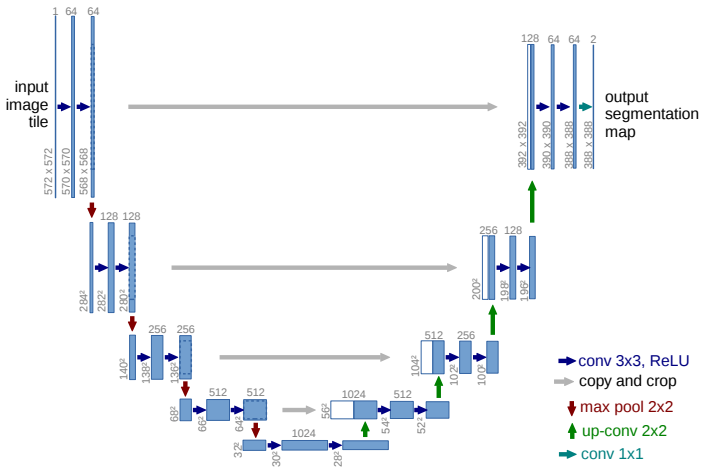

Our architecture still has an encoder and a decoder, as in **SegNet**, but the distinctive feature of this model is *skip-conenctions*, which connect the parts of the decoder and the encoder. That is, in order to transfer a tensor to the input of the decoder, we concatenate the symmetrical output from the encoder and the output of the previous decoder layer.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [59]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            convBatchNormRelu(3, 64, 3, 1, 1),
            convBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            convBatchNormRelu(64, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            convBatchNormRelu(128, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            convBatchNormRelu(256, 512, 3, 1, 1),
            convBatchNormRelu(512, 512, 3, 1, 1),
            convBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            convBatchNormRelu(512, 1024, 1, 1, 0),
            convBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            convBatchNormRelu(512*2, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
            convBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            convBatchNormRelu(256*2, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),
            convBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            convBatchNormRelu(128*2, 64, 3, 1, 1),
            convBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            convBatchNormRelu(64*2, 1, 3, 1, 1),
            convBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

## Unet + bce 

Because of time managment I decided to check only 3 models. Model№1, Model№2 and Model№5. Because third and forth showed worst results and I just dont wanna spent my precious time for that models.

In [60]:
Unet_bce_model1 = UNet().to(device)

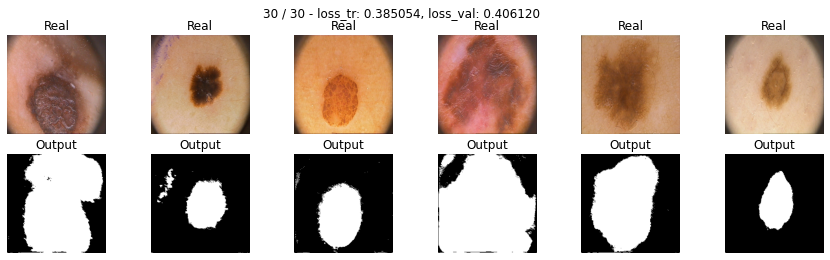

In [61]:
max_epochs = 30
opt = optim.Adam(Unet_bce_model1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(Unet_bce_model1, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [62]:
Unet_bce_model2 = UNet().to(device)

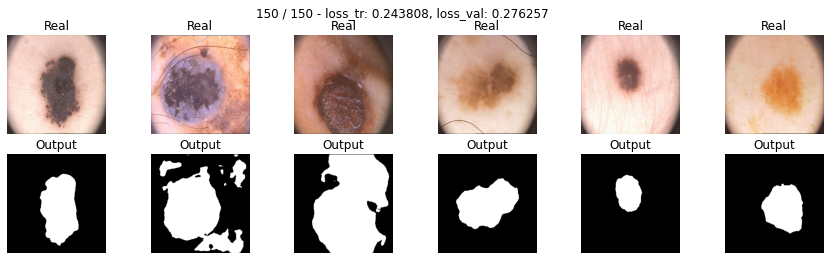

In [63]:
max_epochs = 150
opt = torch.optim.AdamW(Unet_bce_model2.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(Unet_bce_model2, opt, bce_loss, max_epochs, scheduler, data_tr, data_val)

In [64]:
Unet_bce_model5 = UNet().to(device)

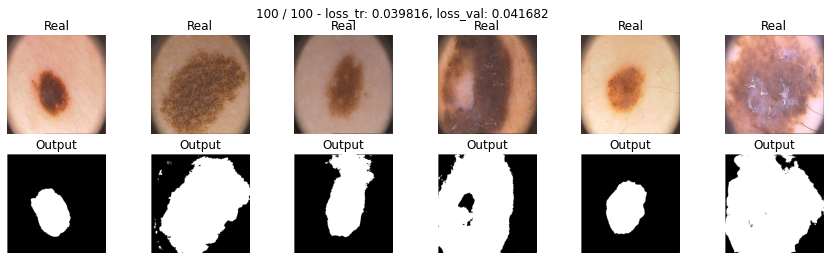

In [65]:
max_epochs = 100
opt = torch.optim.AdamW(Unet_bce_model5.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(Unet_bce_model5, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [83]:
UNet_bce_model1_score = score_model(Unet_bce_model1, iou_pytorch, data_val)
UNet_bce_model2_score = score_model(Unet_bce_model2, iou_pytorch, data_val)
UNet_bce_model5_score = score_model(Unet_bce_model5, iou_pytorch, data_val)

In [84]:
print(f'Score of Unet_bce_model_1 is {UNet_bce_model1_score}')
print(f'Score of Unet_bce_model_2 is {UNet_bce_model2_score}')
print(f'Score of Unet_bce_model_5 is {UNet_bce_model3_score}')

Score of Unet_bce_model_1 is 0.6440000236034393
Score of Unet_bce_model_2 is 0.7899999916553497
Score of Unet_bce_model_5 is 0.69200000166893


**Conclusion:** In this training we could see that model_2 shows better results than others.

**Score: 0.7899999916553497**

In [85]:
segnet_table = pd.DataFrame.from_dict(data={'SegNet with bce loss':[model_score_1, model_score_2, model_score_5],
                                            'UNet with bce loss':[UNet_bce_model1_score, UNet_bce_model2_score, UNet_bce_model1_score]}, 
                                            orient='index', columns=['Model №1', 'Model №2', 'Model №5'])
segnet_table

Model №1  Model №2  Model №5
SegNet with bce loss     0.614      0.72     0.750
UNet with bce loss       0.644      0.79     0.644

As we could see that Unet works better for 2 models of 3. But not so well for model five. Let's see what results Unet with dice will show.

## Unet + Dice

In [71]:
Unet_dice_model1 = UNet().to(device)

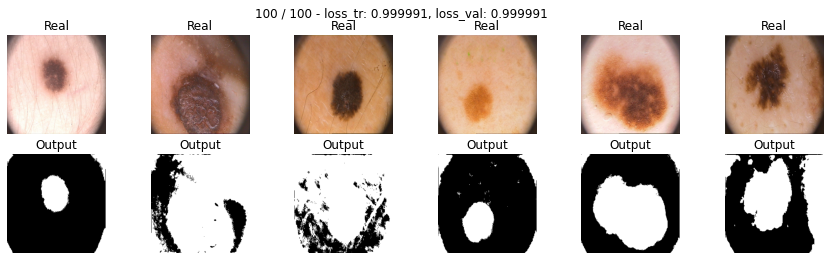

In [72]:
opt = optim.Adam(Unet_dice_model1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(Unet_dice_model1, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [73]:
Unet_dice_model2 = UNet().to(device)

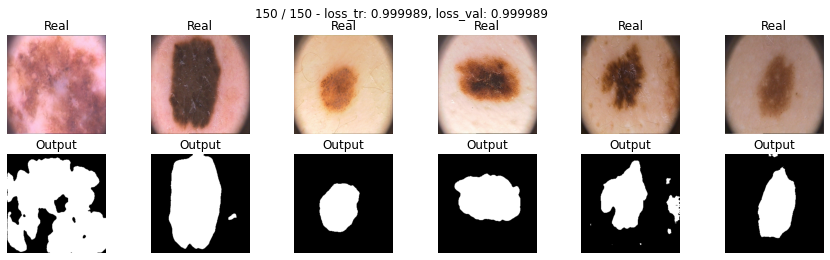

In [74]:
max_epochs = 150
opt = torch.optim.AdamW(Unet_dice_model2.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(Unet_dice_model2, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [75]:
Unet_dice_model5 = UNet().to(device)

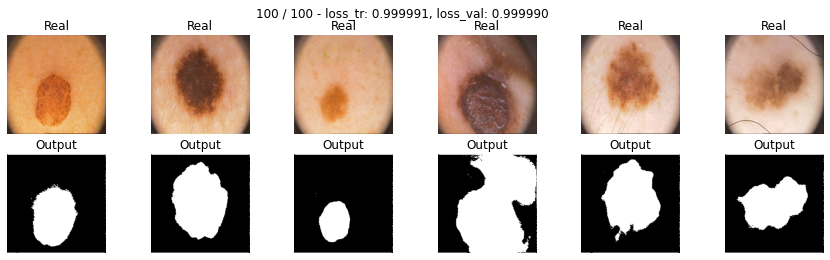

In [76]:
max_epochs = 100
opt = torch.optim.AdamW(Unet_dice_model5.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(Unet_dice_model5, opt, dice_loss, max_epochs, scheduler, data_tr, data_val)

In [81]:
UNet_dice_model1_score = score_model(Unet_dice_model1, iou_pytorch, data_val)
UNet_dice_model2_score = score_model(Unet_dice_model2, iou_pytorch, data_val)
UNet_dice_model5_score = score_model(Unet_dice_model5, iou_pytorch, data_val)

In [82]:
print(f'Score of Unet_dice_model_1 is {UNet_dice_model1_score}')
print(f'Score of Unet_dice_model_2 is {UNet_dice_model2_score}')
print(f'Score of Unet_dice_model_5 is {UNet_dice_model5_score}')

Score of Unet_dice_model_1 is 0.3279999792575836
Score of Unet_dice_model_2 is 0.781999945640564
Score of Unet_dice_model_5 is 0.6680000126361847


**Conclusion:** In this training we could see that model_2 shows better results than others.

**Score: 0.781999945640564**

In [86]:
segnet_table = pd.DataFrame.from_dict(data={'SegNet with dice loss':[model_score_1, model_score_2, model_score_5],
                                            'UNet with dice loss':[UNet_dice_model1_score, UNet_dice_model2_score, UNet_dice_model5_score]}, 
                                            orient='index', columns=['Model №1', 'Model №2', 'Model №5'])

segnet_table

Model №1  Model №2  Model №5
SegNet with dice loss     0.614     0.720     0.750
UNet with dice loss       0.328     0.782     0.668

Here I don't see any regularity. Results are different. Better result has second model. And This result higher than any result of SegNet model with dice loss

## Unet + focal

In [87]:
Unet_focal_model1 = UNet().to(device)

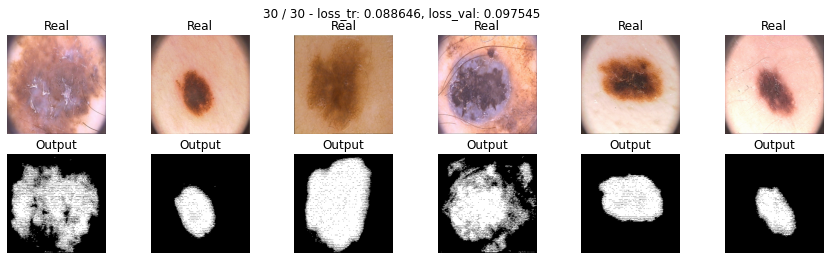

In [88]:
max_epochs = 30
opt = optim.Adam(Unet_focal_model1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
train(Unet_focal_model1, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [89]:
Unet_focal_model2 = UNet().to(device)

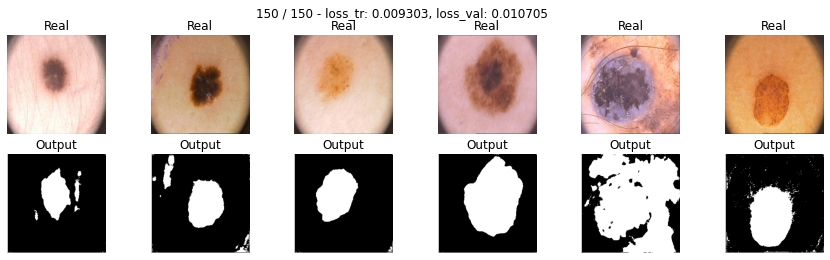

In [90]:
max_epochs = 150
opt = torch.optim.AdamW(Unet_focal_model2.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.8)
train(Unet_focal_model2, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [92]:
Unet_focal_model5 = UNet().to(device)

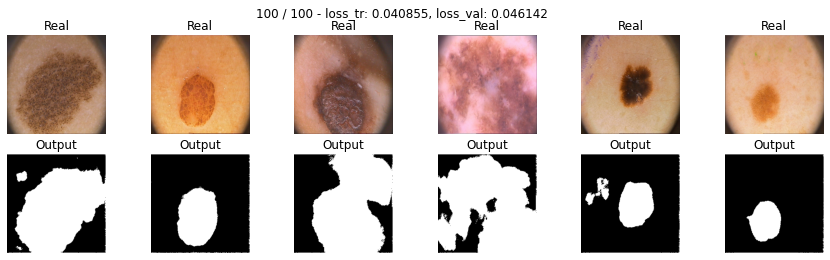

In [93]:
max_epochs = 100
opt = torch.optim.AdamW(Unet_focal_model5.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[30,60], gamma=0.7)
train(Unet_focal_model5, opt, focal_loss, max_epochs, scheduler, data_tr, data_val)

In [94]:
UNet_focal_model1_score = score_model(Unet_focal_model1, iou_pytorch, data_val)
UNet_focal_model2_score = score_model(Unet_focal_model2, iou_pytorch, data_val)
UNet_focal_model5_score = score_model(Unet_focal_model5, iou_pytorch, data_val)

In [95]:
print(f'Score of Unet_focal_model_1 is {UNet_focal_model1_score}')
print(f'Score of Unet_focal_model_2 is {UNet_focal_model2_score}')
print(f'Score of Unet_focal_model_5 is {UNet_focal_model5_score}')

Score of Unet_focal_model_1 is 0.550000011920929
Score of Unet_focal_model_2 is 0.5980000197887421
Score of Unet_focal_model_5 is 0.664000004529953


**Conclusion:** In this training we could see that model_5 shows better results than others.

**Score: 0.664000004529953**

In [96]:
segnet_table = pd.DataFrame.from_dict(data={'SegNet with focal loss':[model_score_1_focal, model_score_2_focal, model_score_5_focal],
                                      'UNet with focal loss':[UNet_focal_model1_score, UNet_focal_model2_score, UNet_focal_model5_score]}, 
                                            orient='index', columns=['Model №1', 'Model №2', 'Model №5'])

segnet_table

Model №1  Model №2  Model №5
SegNet with focal loss     0.616     0.702     0.654
UNet with focal loss       0.550     0.598     0.664

So, at the table we can observe that Unet model perfoms worse. Only Fifth model gave better results but only on 0.01. It is almost nothing. But Model 2 and Model 1 have very bed results in comparison with SegNet + focal loss

## General table for UNet model

In [97]:
unet_table = pd.DataFrame.from_dict(data={'Unet with bce loss':[UNet_bce_model1_score, UNet_bce_model2_score, UNet_bce_model5_score],
                'Unet with dice loss':[UNet_dice_model1_score, UNet_dice_model2_score, UNet_dice_model5_score], 
                'Unet with focal loss':[UNet_focal_model1_score, UNet_focal_model2_score, UNet_focal_model5_score]}, orient='index', columns = ['Model №1', 'Model №2', 'Model №3'])
unet_table

Model №1  Model №2  Model №3
Unet with bce loss       0.644     0.790     0.692
Unet with dice loss      0.328     0.782     0.668
Unet with focal loss     0.550     0.598     0.664

## Conclusion:
1. The best results was demonstrated by UNet with bce loss.
2. The best model is Model №2 with bce loss.
3. Unlike SegNet model which was worse with dice loss UNet works worse with focal loss.
4. I can not say for sure that UNet model is better overall. WIth some models it works better with others worse.

Let's see all models with test sample results not validation as it was earlier.

In [109]:
test_score_dict = {'SegNet_bce_1': score_model(model_1, iou_pytorch, data_ts),
                   'SegNet_bce_2': score_model(model_2, iou_pytorch, data_ts),
                   'SegNet_bce_5': score_model(model_5, iou_pytorch, data_ts),
                   'SegNet_dice_1': score_model(model_1_dice, iou_pytorch, data_ts),
                   'SegNet_dice_2': score_model(model_2_dice, iou_pytorch, data_ts),
                   'SegNet_dice_5': score_model(model_5_dice, iou_pytorch, data_ts),
                   'SegNet_focal_1': score_model(model_1_focal, iou_pytorch, data_ts),
                   'SegNet_focal_2': score_model(model_2_focal, iou_pytorch, data_ts),
                   'SegNet_focal_5': score_model(model_5_focal, iou_pytorch, data_ts),
                   'Unet_bce_1': score_model(Unet_bce_model1, iou_pytorch, data_ts), 
                   'Unet_bce_2': score_model(Unet_bce_model2, iou_pytorch, data_ts),
                   'Unet_bce_5': score_model(Unet_bce_model5, iou_pytorch, data_ts),
                   'Unet_dice_1': score_model(Unet_dice_model1, iou_pytorch, data_ts),
                   'Unet_dice_2': score_model(Unet_dice_model2, iou_pytorch, data_ts),
                   'Unet_dice_5': score_model(Unet_dice_model5, iou_pytorch, data_ts),
                   'Unet_focal_1': score_model(Unet_focal_model1, iou_pytorch, data_ts), 
                   'Unet_focal_2': score_model(Unet_focal_model2, iou_pytorch, data_ts),
                   'Unet_focal_5': score_model(Unet_focal_model5, iou_pytorch, data_ts),}

In [99]:
test_score_list_sort = [(k, v) for k, v in sorted(test_score_dict.items(), key=lambda item: item[1], reverse=True)]
test_score_table = pd.DataFrame(test_score_list_sort, columns=['Model', 'Test_score'])
test_score_table

Model  Test_score
0    SegNet_dice_2       0.728
1      Unet_dice_2       0.720
2       Unet_bce_2       0.710
3     SegNet_bce_5       0.666
4     SegNet_bce_2       0.646
5   SegNet_focal_2       0.640
6     Unet_focal_5       0.630
7      Unet_dice_5       0.622
8       Unet_bce_5       0.620
9       Unet_bce_1       0.614
10  SegNet_focal_5       0.602
11   SegNet_dice_1       0.598
12    SegNet_bce_1       0.590
13  SegNet_focal_1       0.574
14    Unet_focal_2       0.562
15   SegNet_dice_5       0.560
16    Unet_focal_1       0.502
17     Unet_dice_1       0.354

**Let's see the same table but on validation sample**

In [110]:
test_score_dict_val = {'SegNet_bce_1': score_model(model_1, iou_pytorch, data_val),
                   'SegNet_bce_2': score_model(model_2, iou_pytorch, data_val),
                   'SegNet_bce_5': score_model(model_5, iou_pytorch, data_val),
                   'SegNet_dice_1': score_model(model_1_dice, iou_pytorch, data_val),
                   'SegNet_dice_2': score_model(model_2_dice, iou_pytorch, data_val),
                   'SegNet_dice_5': score_model(model_5_dice, iou_pytorch, data_val),
                   'SegNet_focal_1': score_model(model_1_focal, iou_pytorch, data_val),
                   'SegNet_focal_2': score_model(model_2_focal, iou_pytorch, data_val),
                   'SegNet_focal_5': score_model(model_5_focal, iou_pytorch, data_val),
                   'Unet_bce_1': score_model(Unet_bce_model1, iou_pytorch, data_val), 
                   'Unet_bce_2': score_model(Unet_bce_model2, iou_pytorch, data_val),
                   'Unet_bce_5': score_model(Unet_bce_model5, iou_pytorch, data_val),
                   'Unet_dice_1': score_model(Unet_dice_model1, iou_pytorch, data_val),
                   'Unet_dice_2': score_model(Unet_dice_model2, iou_pytorch, data_val),
                   'Unet_dice_5': score_model(Unet_dice_model5, iou_pytorch, data_val),
                   'Unet_focal_1': score_model(Unet_focal_model1, iou_pytorch, data_val), 
                   'Unet_focal_2': score_model(Unet_focal_model2, iou_pytorch, data_val),
                   'Unet_focal_5': score_model(Unet_focal_model5, iou_pytorch, data_val),}

In [114]:
test_score_list_sort = [(k, v) for k, v in sorted(test_score_dict.items(), key=lambda item: item[1], reverse=True)]
test_score_table = pd.DataFrame(test_score_list_sort, columns=['Model', 'Test_score'])
test_score_table


Model  Test_score
0    SegNet_dice_2       0.728
1      Unet_dice_2       0.720
2       Unet_bce_2       0.710
3     SegNet_bce_5       0.666
4     SegNet_bce_2       0.646
5   SegNet_focal_2       0.640
6     Unet_focal_5       0.630
7      Unet_dice_5       0.622
8       Unet_bce_5       0.620
9       Unet_bce_1       0.614
10  SegNet_focal_5       0.602
11   SegNet_dice_1       0.598
12    SegNet_bce_1       0.590
13  SegNet_focal_1       0.574
14    Unet_focal_2       0.562
15   SegNet_dice_5       0.560
16    Unet_focal_1       0.502
17     Unet_dice_1       0.354

In [115]:
test_score_list_sort_val = [(k, v) for k, v in sorted(test_score_dict_val.items(), key=lambda item: item[1], reverse=True)]
test_score_table_val = pd.DataFrame(test_score_list_sort_val, columns=['Model', 'Val_score'])
test_score_table_val

Model  Val_score
0       Unet_bce_2      0.790
1    SegNet_dice_2      0.786
2      Unet_dice_2      0.782
3     SegNet_bce_5      0.750
4     SegNet_bce_2      0.720
5   SegNet_focal_2      0.702
6       Unet_bce_5      0.692
7      Unet_dice_5      0.668
8     Unet_focal_5      0.664
9   SegNet_focal_5      0.654
10   SegNet_dice_1      0.650
11      Unet_bce_1      0.644
12  SegNet_focal_1      0.616
13    SegNet_bce_1      0.614
14   SegNet_dice_5      0.614
15    Unet_focal_2      0.598
16    Unet_focal_1      0.550
17     Unet_dice_1      0.328

## Final conclusion
1. We could see that on test sample model model №2 with SegNet + dice is the best. But in validation sample this model only third.
2. As i could notice that UNet model is a bit better but not so much.
3. Anyway top 3 in val sample and test sample is the same models just they have different places.
5. We could see that overall score is lower on test sample either on val sample.
6. I decided not to create a lot of graphs because of amount of models. I think pandas graphs are showing everything well.
